# Analysis of generated data

Analyze experiment results, present findings. Notebook input is data, output is A/B test suggestions.

### (!) talk some more about the goal here

Links to learn more about the business:
- Restaurant [website](http://thaitanicstreetfood.com/)
- Google [live search results](https://www.google.com/search?q=thai+tanic+sausalito) ([backup](https://github.com/onederekchen/thaitanic/blob/main/data/popular_times/full_view.PNG))
- [Menu backup](https://github.com/onederekchen/thaitanic/blob/main/data/menus/thaitanic_menu_original%2010.2020.pdf) (menu has changed since project debut)

### Import libraries

In [1]:
import pandas as pd
pd.options.display.max_rows = 10  # limit huge ouputs
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # plt.style.available

import warnings
warnings.filterwarnings("ignore")  # filter warnings

### Get data

Merge monthly order data into single .csv file. Raw files available on [Github](https://github.com/onederekchen/thaitanic/tree/main/data/raw_data).

In [2]:
path = "../data/raw_data_updated/"

all_months_data = pd.DataFrame()
number_of_files = 0

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])
        number_of_files += 1

# remove unnamed column (fixed for future generations!)
# all_months_data = all_months_data.loc[:, ~all_months_data.columns.str.contains('^Unnamed')]
    
# original code # all_months_data.to_csv('all_data.csv', index=False)  # don't want to re-save csv every time
# all_months_data.to_csv('all_data_updated.csv', index=False)  # don't want to re-save csv every time

print(f"{number_of_files} months of data!")

36 months of data!


In [10]:
# original code # df = pd.read_csv("../data/all_data.csv").sort_values(by='Order Date', ascending=False)
df = pd.read_csv("../data/all_data_updated.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)
df

,Order ID,Item,Quantity Ordered,Price Each,Order Date
0,314272,Red Curry,1,12,2019-12-31 20:59:00
1,314305,Thai Fried Rice,1,12,2019-12-31 20:55:00
2,314297,Yellow Curry,1,12,2019-12-31 20:55:00
3,314261,Pad Thai,1,12,2019-12-31 20:54:00
4,314288,Tom Yum Gai,2,12,2019-12-31 20:53:00
...,...,...,...,...,...
326935,3919,Tom Kha Gai,2,12,2017-01-01 12:04:00
326936,3951,Pad See Ew,1,12,2017-01-01 12:02:00
326937,3940,Red Curry,2,12,2017-01-01 12:02:00
326938,3913,Pumpkin Curry,1,15,2017-01-01 12:02:00


# Clean data

In [11]:
df.isnull().sum()  # suspiciously/conveniently clean

Order ID            0
Item                0
Quantity Ordered    0
Price Each          0
Order Date          0
dtype: int64

In [12]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.dtypes

Order ID                     int64
Item                        object
Quantity Ordered             int64
Price Each                   int64
Order Date          datetime64[ns]
dtype: object

# Augment data

In [13]:
df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Weekday Value'] = df['Order Date'].dt.weekday

df['Hour'] = df['Order Date'].dt.hour

# Explore data

In [14]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Weekday Value,Hour
count,326940.000000,326940.000000,326940.000000,326940.000000,326940.000000,326940.000000,326940.000000,326940.000000
mean,159074.723393,1.581205,12.142941,19.199110,2018.006420,6.826938,3.733376,15.868233
std,89609.185179,0.959682,2.906082,12.810655,0.817137,3.493723,1.709218,2.955906
min,3910.000000,1.000000,6.000000,6.000000,2017.000000,1.000000,1.000000,11.000000
25%,81514.750000,1.000000,12.000000,12.000000,2017.000000,4.000000,2.000000,13.000000
50%,159018.500000,1.000000,12.000000,12.000000,2018.000000,7.000000,4.000000,17.000000
75%,236693.250000,2.000000,12.000000,24.000000,2019.000000,10.000000,5.000000,19.000000
max,314307.000000,15.000000,22.000000,220.000000,2019.000000,12.000000,6.000000,20.000000


The lowest Order ID is 3910: maybe Thaitanic started recording data or switched to a new system in December 2016, and just gave us data from January 2017 onwards.  

We're looking at almost 9000 orders per month. With 36 months of data, about 25 open days per month and 8 open hours per day, we're looking at about 350 orders per day, or 40 orders per hour.

At least half of the orders are just a single item, although someone ordered 15!! items. It's probably a business ordering catering, or maybe someone really likes Thai food. No judgement.

The cheapest item is 6 dollars while the most expensive is 22.

In [15]:
# let's make sure the 15 orders isn't an anomaly

df.groupby('Quantity Ordered').count()

,Order ID,Item,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
Quantity Ordered,,,,,,,,,,
1,206731,206731,206731,206731,206731,206731,206731,206731,206731,206731
2,76121,76121,76121,76121,76121,76121,76121,76121,76121,76121
3,27918,27918,27918,27918,27918,27918,27918,27918,27918,27918
4,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127
5,3855,3855,3855,3855,3855,3855,3855,3855,3855,3855
...,...,...,...,...,...,...,...,...,...,...
10,38,38,38,38,38,38,38,38,38,38
11,9,9,9,9,9,9,9,9,9,9
12,3,3,3,3,3,3,3,3,3,3


Okay, looks like it really is just a few people ordering a bunch of items. It's a relatively tiny amount of orders.

### Item popularity

In [23]:
df.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Weekday Value,Hour
Item,,,,,,,,
Sticky Rice with Mango,4943689943,49091,187278,294546,62987857,212766,116718,494918
Green Curry,2657156838,26557,199332,318684,33521195,114071,61846,263108
Red Curry,2695427239,26471,202608,317652,34072148,114821,62880,267472
Pad Thai,2680502729,26443,202380,317316,34033607,115746,63003,267673
Yellow Curry,2647809934,26382,200664,316584,33745002,113959,62294,265263
...,...,...,...,...,...,...,...,...
Som Tum,625861066,6206,46776,74472,7866244,26579,14671,61816
Nam Kao Tod,600595164,6028,45432,72336,7640179,25554,14172,60155
Yum Woonsen,595402799,6027,48672,78351,7555435,25289,14149,59828


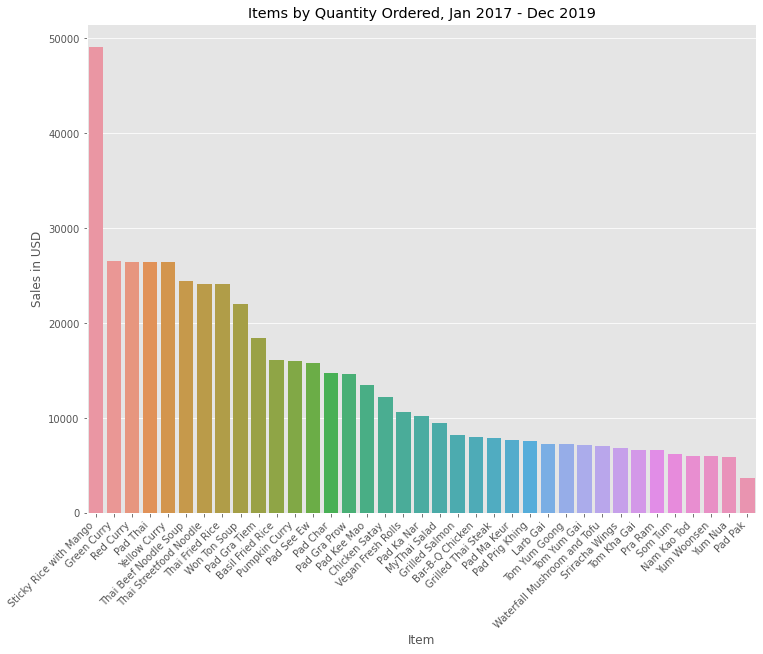

In [17]:
item_popularity = df.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

plt.figure(figsize=(12,9))
ax = sns.barplot(item_popularity.index, item_popularity['Quantity Ordered'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Items by Quantity Ordered, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

Some observations:
- We love sticky rice with mango
- Curries seem to be really popular
- Items with non-English names seem to be less popular
- There's a LOT of menu items
- Significant drop-off in popularity

We don't have expense information, but we could probably save a bunch of money by removing items from the menu. It's expensive to stock a big menu, and not that risky to remove it: if we get rid of an itme, do we think it will cause a customer to eat elsewhere, or to just order something else?

Let's compare against sales next.


> **comment below**
<!-- There's a lot of variation in item orders - we don't have expense information but the restaurant could probably save a lot of money by just not having such a big menu. The variety is nice, but it's expensive to stock so many things.

(!) might be interesting to group this by menu type...

Looks like there's a lot of variation. Also noticing that dishes with non-English names seem to not be selling as well. Might be an idea to switch them to english names?

This is an expenses thing, but it might be a easy change to stop offering the less popular dishes. A bigger menu gives people more variety which is almost never a bad thing, but it's expensive to stock that many different kinds of ingredients.

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

NOTE: there's an infinite amount of analysis you could do here - you could annotate every dish in the menu with coconut and sort by that if you wanted to. Follow your hunches to avoid being distracted by less important stuff. -->

### a great way to think about the menu change: if you make the change, you only need 30% (random num) of your customers to stay to make the same amount of revenue. That assumes you're not also saving money + labor from stocking a bigger menu.

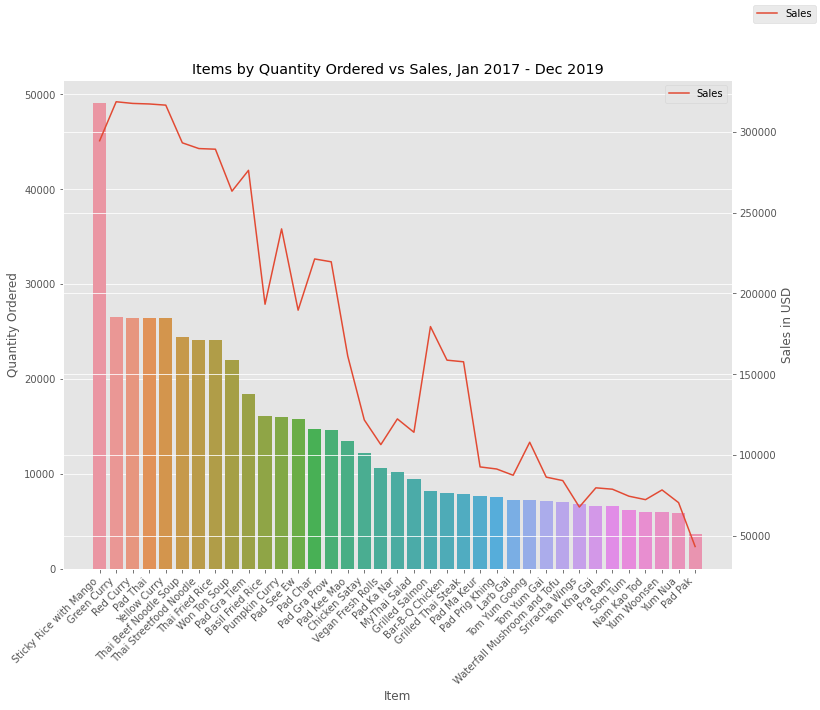

In [20]:
# try to make a dual axis plot...

item_popularity = df.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

plt.figure(figsize=(12,9))
ax = sns.barplot(item_popularity.index, item_popularity['Quantity Ordered'])

ax2 = ax.twinx()
sns.lineplot(item_popularity.index, item_popularity['Sales'], label='Sales')  # consider increasing thickness, changing color

ax.figure.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Items by Quantity Ordered vs Sales, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

Sales is quantity ordered times the price. So even though sticky rice is the most popular, it doesn't make as much money as other dishes because it's cheap.

- Interesting that the most sold item isn't the one generating the most profit.
- The curries and soups are top tier popularity and sales
- There's a dip around appetizers (since they don't cost as much), but they aren't as popular as the sticky rice.
- The BBQ items are expensive... combo them with something to sell more?
- Seriously consider adding English names to the Thai dishes, some of these are so slept on.

**we should be looking to maximize sales** (if we had expense information, we would be trying to maximize profit).

Consider raising the price of sticky rice? (tests elasticity...)

Consider offering combo meals w/ appetizers and profitable meals? The two ways to increase revenue are to get more customers into the restaurant, or to get customers already in the restaurant to spend more. 

**What combos can we offer?** (i'm too tired to figure it out right now... probably pair sticky rice and/or an app w/ bbq items)

In [27]:
# is it worth it to do another visualization but broken down by menu item? maybe add it on the next pass.

In [ ]:
# find some segue into dupes.

### Duplicate values

In [ ]:
dupes_df = df.loc[(df['Order ID'].duplicated(keep=False))]
dupes_df

These look like additional items in the same order since they have the same order ID (so they're not errors).

Let's see if the dupes are any different than the individual products

# (!) NOTE FOR GENERATOR DOCUMENTATION: it's an inaccuracy that additional orders are only one additional order (e.g. no orders with 2 unique additional items)

In [ ]:
dupes_df.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

# sort by sales instead of quantity ordered
# dupes_df.groupby('Product').sum().sort_values(by='Sales', ascending=False)

In [ ]:
# this is an opportunity for a double y axis graph that compares orders with dupes to orders without dupes, right?

Okay, the dupes are overwhelmingly the only dessert item on the menu. There's a drop off in other dishes, but it might just be related to the popularity of those items. What about orders that don't include sticky rice with mango?

Interestingly, sorting by sales gives a noticeably different ordering than just sorting by quantity ordered. Our goal is to give recommendations to maximize sales, so it's something to keep in mind.

In [ ]:
# remove any orders paired with sticky rice

dupes_no_sticky_rice = df.loc[(df['Order ID'].duplicated(keep=False) & ~(df['Product'].str[0:6]=="Sticky"))]
remaining_dupes = dupes_no_sticky_rice.loc[(dupes_no_sticky_rice['Order ID'].duplicated(keep=False))]
remaining_dupes

Looks like it was mostly sticky rice, but there are still other duplicate orders which isn't unusual. Actually, I'm noticing a lot of these seem to be appetizers - let's see if there's a noticeable difference in the amount of appetizers vs other meals.

In [ ]:
# show number of appetizers in duplicate orders (886)
remaining_dupes.loc[(remaining_dupes['Product'].str[0:5]=="Tom K") | 
                   (remaining_dupes['Product'].str[0:5]=="Srira") | 
                   (remaining_dupes['Product'].str[0:5]=="Chick") | 
                   (remaining_dupes['Product'].str[0:5]=="Vegan")]

In [ ]:
# duplicate pairings not including an appetizer (740)
remaining_dupes.loc[~(remaining_dupes['Product'].str[0:5]=="Tom K") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Srira") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Chick") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Vegan")]

It looks like there's some significance here - four appetizers have MORE pairings than all other dishes (excluding desserts). 

##### So our finding is that people very frequently frequently add the dessert the dessert to their order, and people pair the appetizers more than normal meals (but far less than the desserts).

Maybe we can include this as a combo to encourage people to buy more expensive items, or to buy appetizers which don't seem to be especially popular as a pairing.

### more than one order - look after duplicates

In [ ]:
more_than_one_ordered = df.loc[(df['Quantity Ordered'] > 1)]
one_ordered = df.loc[(df['Quantity Ordered'] == 1)]
# len(more_than_one_ordered) + len(one_ordered)
print(len(more_than_one_ordered) / (len(one_ordered) +len(more_than_one_ordered))*100)
more_than_one_ordered

#### (!) Seeing something funny here: there are as many people ordering 9 quantity as there are ordering 3. Seems fishy. Is now the time to fix that? Do I just ignore it?

Let's assume I just didn't find anything useful in quantity ordered.

In [ ]:
# good breakpoint - probably good findings before this

# Best, worst months of sales?

Do I care about sales or orders? Probably sales, right? Because orders just influence sales?

In [ ]:
month_total_sales = df.groupby('Month').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(month_total_sales.index, month_total_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Total Sales by Month")
plt.ylabel("Sales in USD");

This just shows gets us an idea of how much money we're looking at. It's cumulative months, so we'll probably look by month by year in a bit. But this is a quick way to get a picture of where things are.

In [ ]:
year_sales = df.groupby('Year').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(year_sales.index, year_sales['Sales'])

plt.title("2017 - 2019 Sales by Year")
plt.ylabel("Sales in USD (millions)");

Sales look similar between years. Trending upwards, but not significantly enough to note. 2019's sales are 1% higher than 2017's (+$26077 in net sales).

This isn't a new restaurant, so it's likely the demand has settled to the market. It's beyond the scope of this analysis, but you could look at trends for other restaurants in the area to get an idea of how much the area affects sales (as opposed to effort from the restaurant team). 

2019 is also the first year the restaurant exceeded $1M in annual sales. Congrats!

In [ ]:
month_sales = df.groupby(['Year', 'Month']).sum().reset_index()

plt.figure(figsize=(8,6))  # figsize not applying for some reason
ax = sns.barplot(data=month_sales, x='Month', y='Sales')

plt.title("Jan 2017 - Dec 2019 Average Sales by Month")
plt.ylabel("Sales in USD");

# check: most of the highest values are from 2019
# sales_2019 = df.loc[(df['Year']==2019)]
# month_sales_2019 = sales_2019.groupby('Month').sum()
# ax = sns.pointplot(month_sales_2019.index, month_sales_2019['Sales'], marker='.', join=False)

This shows us the average sales per month, as well as the highest and lowest recorded in any year. Note that most of the highest values are from 2019, as the restaurants business has been trending (slightly) upwards.

We mostly see that November and December are significantly higher, and that the summer months are slightly higher. February looks really low, but it might just be because it has slightly less days.

In [ ]:
# average weekday sales with range
weekday_sales_without_monday = df.groupby(['Year', 'Month', 'Weekday Value', 'Weekday']).sum().reset_index()
weekday_sales = pd.DataFrame(columns=weekday_sales_without_monday.columns)

monday_row = {'Weekday': 'Monday', 'Sales': 0}  # show mondays are closed
weekday_sales = weekday_sales.append(monday_row, ignore_index=True)
weekday_sales = pd.concat([weekday_sales, weekday_sales_without_monday]).reset_index(drop=True)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=weekday_sales, x='Weekday', y='Sales')

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Average Sales by Weekday")
plt.ylabel("Sales in USD");

From looking at the weekdays, we see that tuesdays are pretty consistently the least popular days of the week. There's a dip, so could we add money by opening on Mondays instead of Wednesdays?

(!) Note these are really ranges, not confidence intervals. 

#### So the hypothesis is that opening on Mondays instead of Wednesdays will increase sales by X amount. We will open on Mondays for a month, and afterwards will consider it a success if the Monday sales are in X range.

If we make more money over the course of a month on Mondays than we do on Wednesdays, that's obviously a good thing. We can value the experiment by taking the the change in revenue from Monday/Wednesday minus the amount of effort/labor that went into the experiment.

In [ ]:
hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()

# plt.figure(figsize=(8,6))
ax = sns.barplot(data=hour_sales, x='Hour', y='Sales')

# plt.title("Jan 2017 - Dec 2019 Average Sales by Hour")
# plt.ylabel("Sales in USD (millions)");

This gives averages and ranges, but doesn't do a good job showing that there aren't an equal amount of hours. Maybe they should just be open 12-4 every day...

# (!) breakpoint - need to think about this more. will return.

In [ ]:
weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,6))

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=2)

plt.xticks(list(range(24)))
plt.ylabel("Sales in USD (millions)")
plt.title("Jan 2017 - Dec 2019 Total Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

We can see here that Wednesday is pretty much the lowest day (even lower than Tuesday or Thursday), so maybe switching the off day from Monday to Wednesday might be something to try.

At a glance, you might consider changing up weekday hours from 11am-3pm to 12pm-4pm since the sales are higher there. But we can be pretty sure that weekend hours and customer availability are much better on weekends.

# (!) the hours don't seem to be right

In [ ]:
hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()
hour_sales

In [ ]:
# think more about what you're trying to visualize here

weekday = 'Tuesday'
hour= 12

hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()
filter_by_weekday = hour_sales.loc[(hour_sales['Weekday'])==weekday]
filter_by_hour = filter_by_weekday.loc[(filter_by_weekday['Hour'])==hour]
filter_by_hour

ax = sns.lineplot(data=filter_by_weekday, x='Hour', y='Sales', label=weekday, linewidth=2)
# plt.xticks(ticks=[range(24)])

In [ ]:
# filter_by_hour

In [ ]:
# let's get it with a multiindex?

weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()


plt.figure(figsize=(8,6))

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=2)

    
    
plt.xticks(range(24))
plt.ylabel("Sales in USD (millions)")
plt.title("Jan 2017 - Dec 2019 Average Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

In [ ]:
range(24)

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

### Conceptualize restaurant revenue model --> move downwards after exploration complete!

### (?) We can use a conceptual model of the restaurant's revenue to check we haven't missed anything huge.

Now that we've seen the data, let's build a basic business model so we have an idea of what to look for. The restaurant's revenue model can be conceptualized as a product of two major factors:
1. How many people eat at the restaurant? (How many orders will it get?)
2. What do those customers eat? (How much is each order worth?)

We can create a basic revenue model by considering the drivers of those two factors. (Red notes drivers we can directly affect). 

<!-- ![](revenue_model.jpg) -->

Here are some questions that might be helpful to think about during our initial exploration:
* What hours are the best? (check against sales and orders)
* What items are the most popular? (We can try combo meals instead of simply dropping prices)
##### (?) if we increase value offered, will the cost/order go up?

It's out of scope for this notebook, but you could also consider deeper analysis such as:
* Market trends in the area
* Competitive analysis on other restaurants in the area, especially Thai restaurants
* Does the ordering of the menu items affect the menu?

# A/B Test suggestions

1. Close on Wednesdays instead of Mondays (if you were really worried, you could try staying open 7 days/week, but I recognize that's not realistic).
2. Offer combos? (pair w/ marketing of value proposition)

# Non-test recommendations (!) Give insights, ordered recommendations, and suggestions for things to test.

1. Stop offering so many items.
2. Note which items are vegan/vegetarian.
3. Consider hiring help to be open for more hours (instead of closing during the day)

It looks way important to be open for December. Run a calculation that shows just how important. Seriously, hire seasonal help. 


Note on combos: Offering combos increases the value proposition, which might increase the sales from customers who are already in the restaurant. But to really make it worth it (cost-benefit analysis the 'worth-it' here because it might be worth it with that alone), you would want to engage in some kind of marketing, or way to amplify the customers who make it to your store. Marketing your value proposition.

In the next notebook, we'll look at experimental design and assume we weren't the one who did the analysis role.

### Other stuff to add in the future

These are low priority things that are are a bit out of scope, since we already have a bunch of high priority recommendations.
- time series forecast on revenue

# NOTES

I'm just exploring the data. Is there anything specific I can already look for?

1. Sales (break down by times?)

(?) should PRODUCT column just be 'Order' or 'Item'?

(!) order date is time accurate, not order ID... woops.